#### This notebook contains the code for computing the Expression Conservation Coefficient, Mutational Robustness and Fitness Responsivity


### Import Library and Load Model

In [1]:

import sys
sys.path.insert(0, '../')
import aux
from aux import *
#%load_ext autoreload
#%autoreload 2
##Clear Memory 
tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()
##

### Change this flag if you want to load the model on GPU/TPU
if 0: 

    NUM_GPU = len(get_available_gpus())
    if(NUM_GPU>0) :
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

    print(tf.__version__)
    print(keras.__version__)
    #tpu_grpc_url = TPUClusterResolver(tpu=['edv-tpu2'] , zone='us-central1-a').get_master()




    ### Load the Model in a separate graph here as there are two models in this figure.
    fitness_function_graph = tf.Graph()
    with fitness_function_graph.as_default():
        model_conditions='SC_Ura'
        model, scaler,batch_size = load_model(model_conditions)

W1211 04:28:21.229565 47050546986624 deprecation_wrapper.py:119] From ../aux.py:30: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



In [2]:
%load_ext rpy2.ipython

### Figure Specific Functions and Imports

In [3]:
args  = {'sequence_length' : 80}
np.random.seed(0)

#########################################################################################################
#########################################################################################################
### Thanks, Stack Overflow ! 
def mean_(val, freq):
    return np.average(val, weights = freq)

def median_(val, freq):
    ord_ = np.argsort(val)
    cdf = np.cumsum(freq[ord_])
    return val[ord_][np.searchsorted(cdf[-1] // 2, cdf)]

def mode_(val, freq): #in the strictest sense, assuming unique mode
    return val[np.argmax(freq)]

def var_(val, freq):
    if(len(val)==1):
        return 0
    avg = mean_(val, freq)
    dev = freq * (val - avg) ** 2
    return dev.sum() / (freq.sum() - 1)

def std_(val, freq):
    return np.sqrt(var_(val, freq))


#########################################################################################################
def freq_df(pro_ortho_sequences):
    ### Returns : Base Frequency distribution for this set of sequences
    #Verified against : http://hplgit.github.io/bioinf-py/doc/pub/html/main_bioinf.html
    pro_freq_df = pd.DataFrame(index=range(len(pro_ortho_sequences[0])) , columns=['A','C','G','T'] ,
                              data = np.zeros( (len(pro_ortho_sequences[0]),4)))
    for sequence in pro_ortho_sequences : 
        for index,base in enumerate(sequence) : 
            pro_freq_df.loc[index,base]+=1
            
    pro_freq_df = pro_freq_df.div(pro_freq_df.sum(axis=1), axis=0)

    return pro_freq_df

#########################################################################################################
#########################################################################################################
### Generate all possible single mutations in population : population_next 


def population_mutator( population_current , args) :
    population_current = population_remove_flank(population_current)
    population_next = []  
    for i in range(len(population_current)) :         
        for j in range(args['sequence_length']) : 
        #First create three copies of the same individual, one for each possible mutation at the basepair.
            population_next.append(list(population_current[i]))
            population_next.append(list(population_current[i]))
            population_next.append(list(population_current[i]))
            
            if (population_current[i][j] == 'A') :
                population_next[3*(args['sequence_length']*i + j) ][j] = 'C'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'G'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'T'
                
            elif (population_current[i][j] == 'C') :
                population_next[3*(args['sequence_length']*i + j)][j] = 'A'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'G'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'T'
            
            elif (population_current[i][j] == 'G') :
                population_next[3*(args['sequence_length']*i + j)][j] = 'C'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'A'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'T'
                
            elif (population_current[i][j] == 'T') :
                population_next[3*(args['sequence_length']*i + j)][j] = 'C'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'G'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'A'
             
        
    population_next= population_add_flank(population_next)        
    return list(population_next)





#########################################################################################################
#########################################################################################################
#########################################################################################################




#######################################################################################
#######################################################################################
#######################################################################################

def closest_point(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

#######################################################################################
#######################################################################################
#######################################################################################

def get_snpdev_dist(population) : 
    population_fitness = np.array(evaluate_model(list(population),model,scaler,batch_size,fitness_function_graph))
    args  = {'sequence_length' : 80 , 'nucleotide_frequency' :[0.25,0.25,0.25,0.25] , 'randomizer' : np.random } 
    population_1bp_all_sequences = population_mutator(list(population) , args)
    population_1bp_all_fitness = np.array(evaluate_model(list(population_1bp_all_sequences),model,scaler,batch_size,fitness_function_graph))


    snpdev_dist = []
    for i in (range(len(population))) :   
        original_fitness = population_fitness[i]
        sequence = population[i]

        exp_dist = population_1bp_all_fitness[3*args['sequence_length']*i:3*args['sequence_length']*(i+1)]
        snpdev_dist = snpdev_dist + [np.sort((exp_dist-original_fitness))]

    sequences = population
    return snpdev_dist


#######################################################################################
#######################################################################################
#######################################################################################


def analyze_seq(population ) : 
    ### Quick function to generate an analyzed dataframe for any sequence. Only works in this NB.

    data_at = AAnet_model.data2at(get_snpdev_dist(population))
    Y_mds_data = data_at @ Y_mds_ats
    
    data_at_df = pd.DataFrame(data_at , columns = ['AT1','AT2','AT3']).join(
    pd.DataFrame(Y_mds_data , columns = ['MDS1','MDS2'])).join(
    pd.DataFrame(evaluate_model(population,model,scaler,batch_size,fitness_function_graph),
                 columns = [model_conditions+'_exp']))
    return data_at_df, data_at , Y_mds_data

#######################################################################################
#######################################################################################
#######################################################################################


def snpdev_str_to_list(snpdev_str) : 
    return [float(i) for i in snpdev_str.replace("\n" , "").replace("[","").replace("]","").split()]

def name2sys(gene_name):
    return yeast_genome_annotations[yeast_genome_annotations.gene_name==gene_name].systematic_name.values[0]
#########################################################################################################
%matplotlib inline

# Compute the ECC

### Load 1011 genomes ortholog data

In [4]:

if 1 : 

    ortho_sequences_df = pd.read_csv('./20190719_Native80.2_orthologous_promoters_unique.txt.gz', sep='\t')
    ortho_sequences_df = ortho_sequences_df[~ortho_sequences_df.ortho_seq.str.contains('N')]
    nonunique_ortho_sequences_df = pd.read_csv('./20190719_Native80.2_orthologous_promoters.txt.gz', sep='\t')
    nonunique_ortho_sequences_df = nonunique_ortho_sequences_df[~nonunique_ortho_sequences_df.ortho_seq.str.contains('N')]
    ### Compute Expression
    ortho_sequences_df['EL'] = evaluate_model(list(ortho_sequences_df.ortho_seq), 
                                                      model,scaler,batch_size,fitness_function_graph)

    ortho_sequences = list(ortho_sequences_df['ortho_seq'].values)
    if len(ortho_sequences[0])==80 :
        ortho_sequences = population_add_flank(list(ortho_sequences))

    ### List of Unique Promoters
    proName_list = np.unique(ortho_sequences_df.proName.values)

## Compute variance in simulated Expression across orthologs for each promoter as control

### First Get the Base Frequency and Consensus Sequences

In [6]:
if 1 : 
    def freq_df_par(pro):
        return freq_df(nonunique_ortho_sequences_df[nonunique_ortho_sequences_df.proName==pro].ortho_seq.values)

    num_cores = multiprocessing.cpu_count()-5
    pool = mp.Pool(num_cores)
    freq_df_list = pool.map(  freq_df_par, tqdm(proName_list))
    pool.close()
    pool.join()

    pro_freq_dict = dict(zip(proName_list, freq_df_list))

    pro_consensus_dict = {}
    for pro in proName_list :
        pro_consensus_dict[pro] = ''.join(pro_freq_dict[pro].idxmax(axis=1))

    ### Number of Consensus sequences that correspond to real promoters is 99% 
    print(len(np.intersect1d(list(ortho_sequences_df.ortho_seq.values),list(pro_consensus_dict.values()))))

    f = open("pro_consensus_dict.pkl","wb")
    pickle.dump(pro_consensus_dict,f)
    f.close()

    np.save('pro_consensus_dict.npy' , pro_consensus_dict)
pro_consensus_dict = np.load('pro_consensus_dict.npy', allow_pickle=1).item()
proName_list = list(pro_consensus_dict.keys())

### Simulate N control sequences by mutating the consensus at k positions with this base frequency

In [7]:
if 1:
    def find_k(i):
        seq= nonunique_ortho_sequences_df.ortho_seq[i]
        reference = pro_consensus_dict[nonunique_ortho_sequences_df.proName[i]] # pro_df.loc[nonunique_ortho_sequences_df.proName[i]].reference_sequence#
        return int(hamming_distance(seq , reference))

    num_cores = multiprocessing.cpu_count()-5
    pool = mp.Pool(num_cores)
    nonunique_ortho_sequences_df['k'] = pool.map(  find_k,  (nonunique_ortho_sequences_df.index))
    pool.close()
    pool.join()



    def find_k_unique(i):
        seq= ortho_sequences_df.ortho_seq[i]
        reference = pro_consensus_dict[ortho_sequences_df.proName[i]] #pro_df.loc[ortho_sequences_df.proName[i]].reference_sequence#
        return int(hamming_distance(seq , reference))

    num_cores = multiprocessing.cpu_count()-5
    pool = mp.Pool(num_cores)
    ortho_sequences_df['k'] = pool.map(  find_k_unique,  (ortho_sequences_df.index))
    pool.close()
    pool.join()

    ortho_sequences_df['EL'] = evaluate_model(list(ortho_sequences_df.ortho_seq), 
                                                      model,scaler,batch_size,fitness_function_graph)
    nonunique_ortho_sequences_df['EL'] = nonunique_ortho_sequences_df.ortho_seq.map(
        dict(zip(ortho_sequences_df.ortho_seq,ortho_sequences_df.EL)))
    ortho_sequences_df.to_csv('ortho_sequences_df_analyzed.tsv', sep='\t')
    nonunique_ortho_sequences_df.to_csv('nonunique_ortho_sequences_df_analyzed.tsv', sep='\t')



ortho_sequences_df = pd.read_csv('ortho_sequences_df_analyzed.tsv', sep='\t' , index_col=0)
nonunique_ortho_sequences_df = pd.read_csv('nonunique_ortho_sequences_df_analyzed.tsv', sep='\t' , index_col=0)


/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Compute and plot variance in Actual Expression across orthologs for each promoter

In [8]:
if 1: 
    pro_df = pd.DataFrame(index=proName_list , columns = {'var_EL_actual','var_EL_sim'})
    for i in tqdm(proName_list):
        ortho_subset= ortho_sequences_df[ortho_sequences_df.proName==i]
        pro_df.loc[i,'var_EL_actual'] = var_(ortho_subset.EL , ortho_subset.num_isolates)
        #pro_df.loc[i,'var_EL_actual_unweighted'] = np.var(ortho_subset.EL)

    ref_df=pd.read_csv(os.path.join('..','..','data','native_sequences_only','allNativeChunks.all') , 
                header=None , sep='\t',index_col=0 , names=['reference_sequence'])#.loc[pro_df.index].values


    pro_df = pro_df.join(ref_df)
    #pro_stats = pd.read_csv('/ahg/regevdata/projects/GeneRegModeling/SingleCellPGM/GPRA/Evolution/1002_yeast_genomes/analysis/20190719_Native80.2_promoter_divergence.txt',
    #                   sep='\t' , index_col=0)
    #pro_df = pro_df.join(pro_stats )

#if 0 : 
    #pro_df = pd.read_csv('./pro_df_analyzed.tsv',sep='\t', index_col=0)

    proName_list  = pro_df.index.values

In [9]:
### Randomize separately for each non unique sequence
if 1 : 
    pro_sim_seqs_dict = {}
    pro_sim_exp_dict = {}
    pro_sim_var_dict = {}

    def sim_seqs_nonunique(pro) :
        df = nonunique_ortho_sequences_df[nonunique_ortho_sequences_df.proName==pro]
        reference = pro_consensus_dict[pro]
        pro_sim_seqs_dict[pro]= []


        new_seq_list = []
        for i in (df.index): 
            k = df.k[i]
            position_list = np.random.choice(len(reference),k,replace=False)

            new_seq = list(copy.deepcopy(reference))
            for position in position_list :
                new_seq[position] = np.random.choice(np.setdiff1d(['A','C','G','T'],new_seq[position]))

            new_seq_list = new_seq_list + [''.join(new_seq)]

        return new_seq_list


    num_cores = multiprocessing.cpu_count()-5
    pool = mp.Pool(num_cores)
    list_of_new_seq_list = pool.map(  sim_seqs_nonunique,   (proName_list))
    pool.close()
    pool.join()
    pro_sim_seqs_dict = dict(zip(proName_list, list_of_new_seq_list))



    #sim_df = pd.DataFrame({'proName':proName_list[0] ,'sim_seq':pro_sim_seqs_dict[proName_list[0]] })
    #for pro in (proName_list[1:]) :
    #    sim_df = sim_df.append(pd.DataFrame({'proName':pro ,'sim_seq':pro_sim_seqs_dict[pro] }) )




    #pro_sim_exp_dict[pro] = evaluate_model(pro_sim_seqs_dict[pro] ,model, scaler, batch_size,fitness_function_graph )
    #pro_sim_var_dict[pro] = np.var(pro_sim_exp_dict[pro])

In [10]:
# Testing the weighted variance function. it works 
if 1 : 
    pro = proName_list[0]#.split('.')[0]
    sim_df = pd.DataFrame({'proName':pro ,'sim_seq':pro_sim_seqs_dict[pro] })
    sim_unique_df = pd.DataFrame(sim_df.sim_seq.value_counts()).rename(columns={'sim_seq':'num_isolates'})
    sim_unique_df['sim_seq'] = sim_unique_df.index
    sim_unique_df=sim_unique_df.reset_index().drop(columns='index') ##
    sim_unique_df['EL'] = evaluate_model(list(sim_unique_df.sim_seq), model,scaler,batch_size,fitness_function_graph)
    sim_df['EL'] = evaluate_model(list(sim_df.sim_seq), model,scaler,batch_size,fitness_function_graph)
    print(var_(sim_unique_df.EL , sim_unique_df.num_isolates) , np.var(sim_df.EL))

In [11]:
if 1 : 
    sim_unique_df_full = []
    for i in tqdm(range(len(proName_list))):
        pro = proName_list[i]
        sim_df = pd.DataFrame({'proName':pro ,'sim_seq':pro_sim_seqs_dict[pro] })
        sim_unique_df = pd.DataFrame(sim_df.sim_seq.value_counts()).rename(columns={'sim_seq':'num_isolates'})
        sim_unique_df['sim_seq'] = sim_unique_df.index
        sim_unique_df=sim_unique_df.reset_index().drop(columns='index') ##
        sim_unique_df.index = sim_unique_df.index +'_'+pro
        sim_unique_df['proName']=pro

        if(i==0):
            sim_unique_df_full = (sim_unique_df)

        else :
            sim_unique_df_full = sim_unique_df_full.append(sim_unique_df)


    sim_unique_df_full['EL'] = evaluate_model(list(sim_unique_df_full.sim_seq), 
                                                      model,scaler,batch_size,fitness_function_graph)
    sim_unique_df_full.to_csv('sim_unique_df_full', sep='\t')


    for pro in tqdm(proName_list):
        sim_subset= sim_unique_df_full[sim_unique_df_full.proName==pro]
        pro_df.loc[pro,'var_EL_sim'] = var_(sim_subset.EL , sim_subset.num_isolates)
    

sim_unique_df_full = pd.read_csv('./sim_unique_df_full.tsv',sep='\t', index_col=0)




In [12]:
### Randomize separately for each non unique sequence
if 1 : 
    pro_sim_seqs_dict = {}
    pro_sim_exp_dict = {}
    pro_sim_var_dict = {}

    def sim_seqs_v2(pro) :
        df = ortho_sequences_df[ortho_sequences_df.proName==pro]
        reference = pro_consensus_dict[pro]
        pro_sim_seqs_dict[pro]= []


        new_seq_list = []
        for i in (df.index): 
            k = df.k[i]
            position_list = np.random.choice(len(reference),k,replace=False)

            new_seq = list(copy.deepcopy(reference))
            for position in position_list :
                new_seq[position] = np.random.choice(np.setdiff1d(['A','C','G','T'],new_seq[position]))

            new_seq_list = new_seq_list + [''.join(new_seq)]

        return new_seq_list


    num_cores = multiprocessing.cpu_count()-5
    pool = mp.Pool(num_cores)
    list_of_new_seq_list = pool.map(  sim_seqs_v2,   (proName_list))
    pool.close()
    pool.join()
    pro_sim_seqs_dict_v2 = dict(zip(proName_list, list_of_new_seq_list))


    flat_list_of_new_seq_list = list()
    for i in list_of_new_seq_list:
        for j in i :
            flat_list_of_new_seq_list.append(j)
   

    sim_unique_df_full_v2 = copy.deepcopy(ortho_sequences_df)
    sim_unique_df_full_v2['sim_seq'] = flat_list_of_new_seq_list
    sim_unique_df_full_v2['EL'] = evaluate_model(list(sim_unique_df_full_v2.sim_seq), 
                                                      model,scaler,batch_size,fitness_function_graph)
    
    sim_unique_df_full_v2.to_csv('sim_unique_df_full_v2', sep='\t')

sim_unique_df_full_v2 = pd.read_csv('./sim_unique_df_full_v2',sep='\t', index_col=0)



In [13]:
if 1 :
    for pro in tqdm(proName_list):
        sim_subset= sim_unique_df_full[sim_unique_df_full.proName==pro]
        pro_df.loc[pro,'std_EL_sim'] = std_(sim_subset.EL , sim_subset.num_isolates) #STD not var, ignore name
        pro_df.loc[pro,'var_EL_sim'] = var_(sim_subset.EL , sim_subset.num_isolates) #STD not var, ignore name

        sim_subset_v2= sim_unique_df_full_v2[sim_unique_df_full_v2.proName==pro]
        pro_df.loc[pro,'std_EL_sim_v2'] = std_(sim_subset_v2.EL , sim_subset_v2.num_isolates)#STD not var, ignore name
        pro_df.loc[pro,'var_EL_sim_v2'] = var_(sim_subset_v2.EL , sim_subset_v2.num_isolates)#STD not var, ignore name

        ortho_subset= ortho_sequences_df[ortho_sequences_df.proName==pro]
        pro_df.loc[pro,'std_EL_actual'] = std_(ortho_subset.EL , ortho_subset.num_isolates)#STD not var, ignore name
        pro_df.loc[pro,'var_EL_actual'] = var_(ortho_subset.EL , ortho_subset.num_isolates)#STD not var, ignore name


    pro_df['uncorrected_ratio'] =  (pro_df.std_EL_sim+(np.finfo(float).eps)) / (pro_df.std_EL_actual +(np.finfo(float).eps))
    pro_df['uncorrected_log_ratio'] = pro_df.uncorrected_ratio.astype('float').apply(np.log2)
    
    pro_df['ratio_v2'] =  (pro_df.std_EL_sim_v2+(np.finfo(float).eps)) / (pro_df.std_EL_actual +(np.finfo(float).eps))
    pro_df['log_ratio_v2'] = pro_df.ratio_v2.astype('float').apply(np.log2)

    pro_consensus_dict_df = pd.DataFrame.from_dict(pro_consensus_dict , orient='index')
    pro_consensus_dict_df.columns = ['consensus_sequence']
    pro_df = pro_df.join(pro_consensus_dict_df)
    
    pro_ref_pred_EL_df = pd.read_csv(os.path.join('..','..','data','native_sequences_only','pro_ref_pred_SC_URA_GLU_EL.tsv'), sep='\t' ,
                   index_col = 0 )
    pro_df = pro_df.join(pro_ref_pred_EL_df.loc[pro_df.index , ['pred_ref_SC_Ura_EL' , 'pred_ref_Glu_EL']])
    
    pro_df.loc[pro_df.var_EL_actual==0,'uncorrected_log_ratio']=np.nan
    pro_df.loc[pro_df.var_EL_actual==0,'uncorrected_ratio']=np.nan
    
    pro_df.loc[pro_df.var_EL_actual==0,'log_ratio']=np.nan
    pro_df.loc[pro_df.var_EL_actual==0,'ratio']=np.nan
    
    pro_df.loc[pro_df.var_EL_actual==0,'log_ratio_v2']=np.nan
    pro_df.loc[pro_df.var_EL_actual==0,'ratio_v2']=np.nan
    
    
    pro_df['ratio_sim_sim'] =  (pro_df.std_EL_sim+(np.finfo(float).eps)) / (pro_df.std_EL_sim_v2 +(np.finfo(float).eps))
    pro_df['log_ratio_sim_sim'] = pro_df.ratio_sim_sim.astype('float').apply(np.log2)
    sim_sim_median = np.median(pro_df['log_ratio_sim_sim'])

    pro_df['log_ratio'] = pro_df['uncorrected_log_ratio'] - sim_sim_median
    pro_df.to_csv('pro_df_analyzed.tsv',sep='\t')
    


### Check the Distribution of the simulation (for control) and the real data . Make sure it is the same !
(Unit Tests)

In [29]:
if 1  :
    pro = np.random.choice(proName_list)
    test_sim_df=sim_unique_df_full[sim_unique_df_full.proName==pro]
    test_ortho_df = ortho_sequences_df[ortho_sequences_df.proName==pro]
    test_nonunique_ortho_df = nonunique_ortho_sequences_df[nonunique_ortho_sequences_df.proName==pro]

    test_sim_df['k'] = [hamming_distance(seq,pro_df.loc[pro,'consensus_sequence']) for seq in test_sim_df.sim_seq.values]
    test_ortho_df['k'] = test_ortho_df.k.values
    #k_true_unique = test_ortho_df.k.values

    sim_k_df = pd.DataFrame(data=np.zeros((1,len(np.unique(test_sim_df['k'])))),columns=np.unique(test_sim_df['k'] ))
    for j in test_sim_df.index :
        sim_k_df[test_sim_df.loc[j].k] +=test_sim_df.loc[j].num_isolates

    true_k_df = pd.DataFrame(data=np.zeros((1,len(np.unique(test_ortho_df['k'])))),columns=np.unique(test_ortho_df['k'] ))
    for j in test_ortho_df.index :
        true_k_df[test_ortho_df.loc[j].k] +=test_ortho_df.loc[j].num_isolates

    print('Does it work for ' + pro + ' : ' + str(np.all(true_k_df == sim_k_df))) 

Does it work for YJL076W.2 : True


/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
log_ratio_values = (pro_df.log_ratio.values)

In [31]:
%%R -i log_ratio_values -o log_ratio_binomial_P -o fraction_stabilizing_selection
fraction_stabilizing_selection = sum(log_ratio_values>0, na.rm=T)/sum(!is.na(log_ratio_values))
log_ratio_binomial_P = pbinom(q=sum(log_ratio_values>0, na.rm=T), size=sum(!is.na(log_ratio_values)), prob=0.5, lower.tail=F)

/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


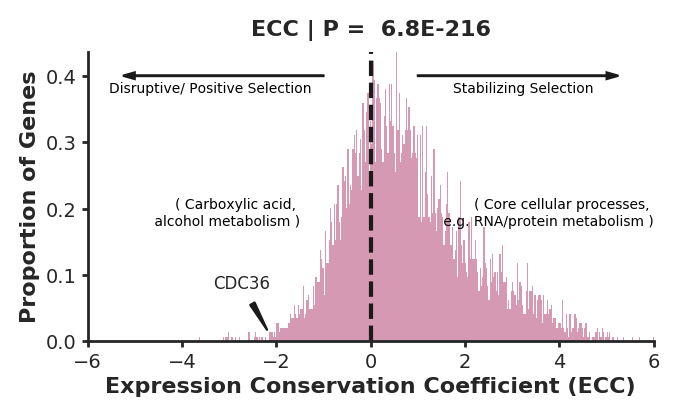

In [32]:
fig_file = "1011_isolate_log_ratio"
plot_df = pro_df#[~pro_df.ratio.isna()]#pro_df[pro_df.ratio<pro_df["ratio"].quantile(0.999999)]


fig=plt.figure(figsize=(3.5,3.5/1.6) ,dpi= 200, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


#sns.distplot(plot_df.log_ratio.dropna() , kde=False, rug = 0  , color = '#fa9fb5')#

sns.distplot(plot_df.log_ratio.dropna(), color= '#980043', hist =1, bins=500,
             kde=0,#kde_kws={'cumulative':0, 'shade':1} , 
             hist_kws={'linewidth':0 , 'density':1})

plt.axvline(0, 0 , c='k' , linestyle = '--')

ax = plt.gca()
#ax.get_legend().remove()
if 0 : 
    ax.annotate('Neutral Evolution', xy=(0, 0.0125),  xycoords='data', fontsize=6,
                xytext=(5.5 ,0.045 ), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right',verticalalignment='top'
                )


    ax.annotate('Disruptive/\n Positive Selection', xy=(-1, 0.03),  xycoords='data', fontsize=6,
                xytext=(-1, 0.165), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )


    ax.annotate('Stabilizing Selection', xy=(4, 0.02),  xycoords='data', fontsize=6,
                xytext=(6, 0.1), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )

ax.annotate('CDC36', xy=(pro_df.loc['YDL165W.2' , 'log_ratio'], 0.01),  xycoords='data', fontsize=6,
                xytext=(pro_df.loc['YDL165W.2' , 'log_ratio'], 0.1), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )

plt.arrow(1,0.4,4,0,head_width=0.01, head_length=0.25, fc='k', ec='k')
plt.text(x=1.75, y=0.375,s='Stabilizing Selection', horizontalalignment='left', 
             size='medium', color='black', weight='medium', fontsize=5)


plt.arrow(-1,0.4,-4,0,head_width=0.01, head_length=0.25, fc='k', ec='k')
plt.text(x=-1.25, y=0.375,s='Disruptive/ Positive Selection', horizontalalignment='right', 
             size='medium', color='black', weight='medium', fontsize=5)


plt.text(x=-1.5, y=0.175,s='( Carboxylic acid, \n alcohol metabolism )', horizontalalignment='right', 
             size='medium', color='black', weight='medium', fontsize=5)


plt.text(x=6, y=0.175,s='( Core cellular processes, \n e.g. RNA/protein metabolism )', horizontalalignment='right', 
             size='medium', color='black', weight='medium', fontsize=5)

ax.set_xlabel("Expression Conservation Coefficient (ECC)" )
ax.set_ylabel("Proportion of Genes")
ax.set_title(f"ECC | P = {log_ratio_binomial_P[0] : 0.1E}")



plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim(xmin=-6,xmax=6)
#ax.set_ylim(ymin=0,ymax=0.4)




plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()




### Compute Mutational Robustness 
( referred to in the code as mutation_tolerance)

In [37]:

cons_df = pro_df[pro_df.log_ratio>0]
epsilon = 2*std_(cons_df.var_EL_actual.values.astype(np.float64) ,cons_df.num_valid_hamming.values )
print('Epsilon : ' + str(epsilon))

Epsilon : 0.16161806992748126


In [38]:
### Compute Mutation Tolerance and total absolute deviation
if 1:
    reference_snpdev_dist = get_snpdev_dist(population_add_flank(list(pro_df.reference_sequence)))
    consensus_snpdev_dist = get_snpdev_dist(population_add_flank(list(pro_df.consensus_sequence)))
    
    mutation_tolerance = ((np.abs(consensus_snpdev_dist) -epsilon)<0).sum(axis=1) / len(consensus_snpdev_dist[0])
    pro_df['mutation_tolerance']=mutation_tolerance
    mutation_tolerance_half_epsilon = ((np.abs(consensus_snpdev_dist) -(epsilon/2))<0).sum(axis=1) / len(consensus_snpdev_dist[0])
    pro_df['mutation_tolerance_half_epsilon']=mutation_tolerance_half_epsilon


    ref_mutation_tolerance_half_epsilon = ((np.abs(reference_snpdev_dist) -(epsilon/2))<0).sum(axis=1) / len(reference_snpdev_dist[0])
    pro_df['ref_mutation_tolerance_half_epsilon']=ref_mutation_tolerance_half_epsilon

    ref_mutation_tolerance_epsilon = ((np.abs(reference_snpdev_dist) -(epsilon))<0).sum(axis=1)/ len(reference_snpdev_dist[0])
    pro_df['ref_mutation_tolerance_epsilon']=ref_mutation_tolerance_epsilon




    pro_df['absolute_deviation']=np.sum(np.abs(consensus_snpdev_dist) , 1)
    pro_df['ref_absolute_deviation']=np.sum(np.abs(reference_snpdev_dist) ,1 )
    
    pro_df.to_csv('pro_df_analyzed.tsv',sep='\t')





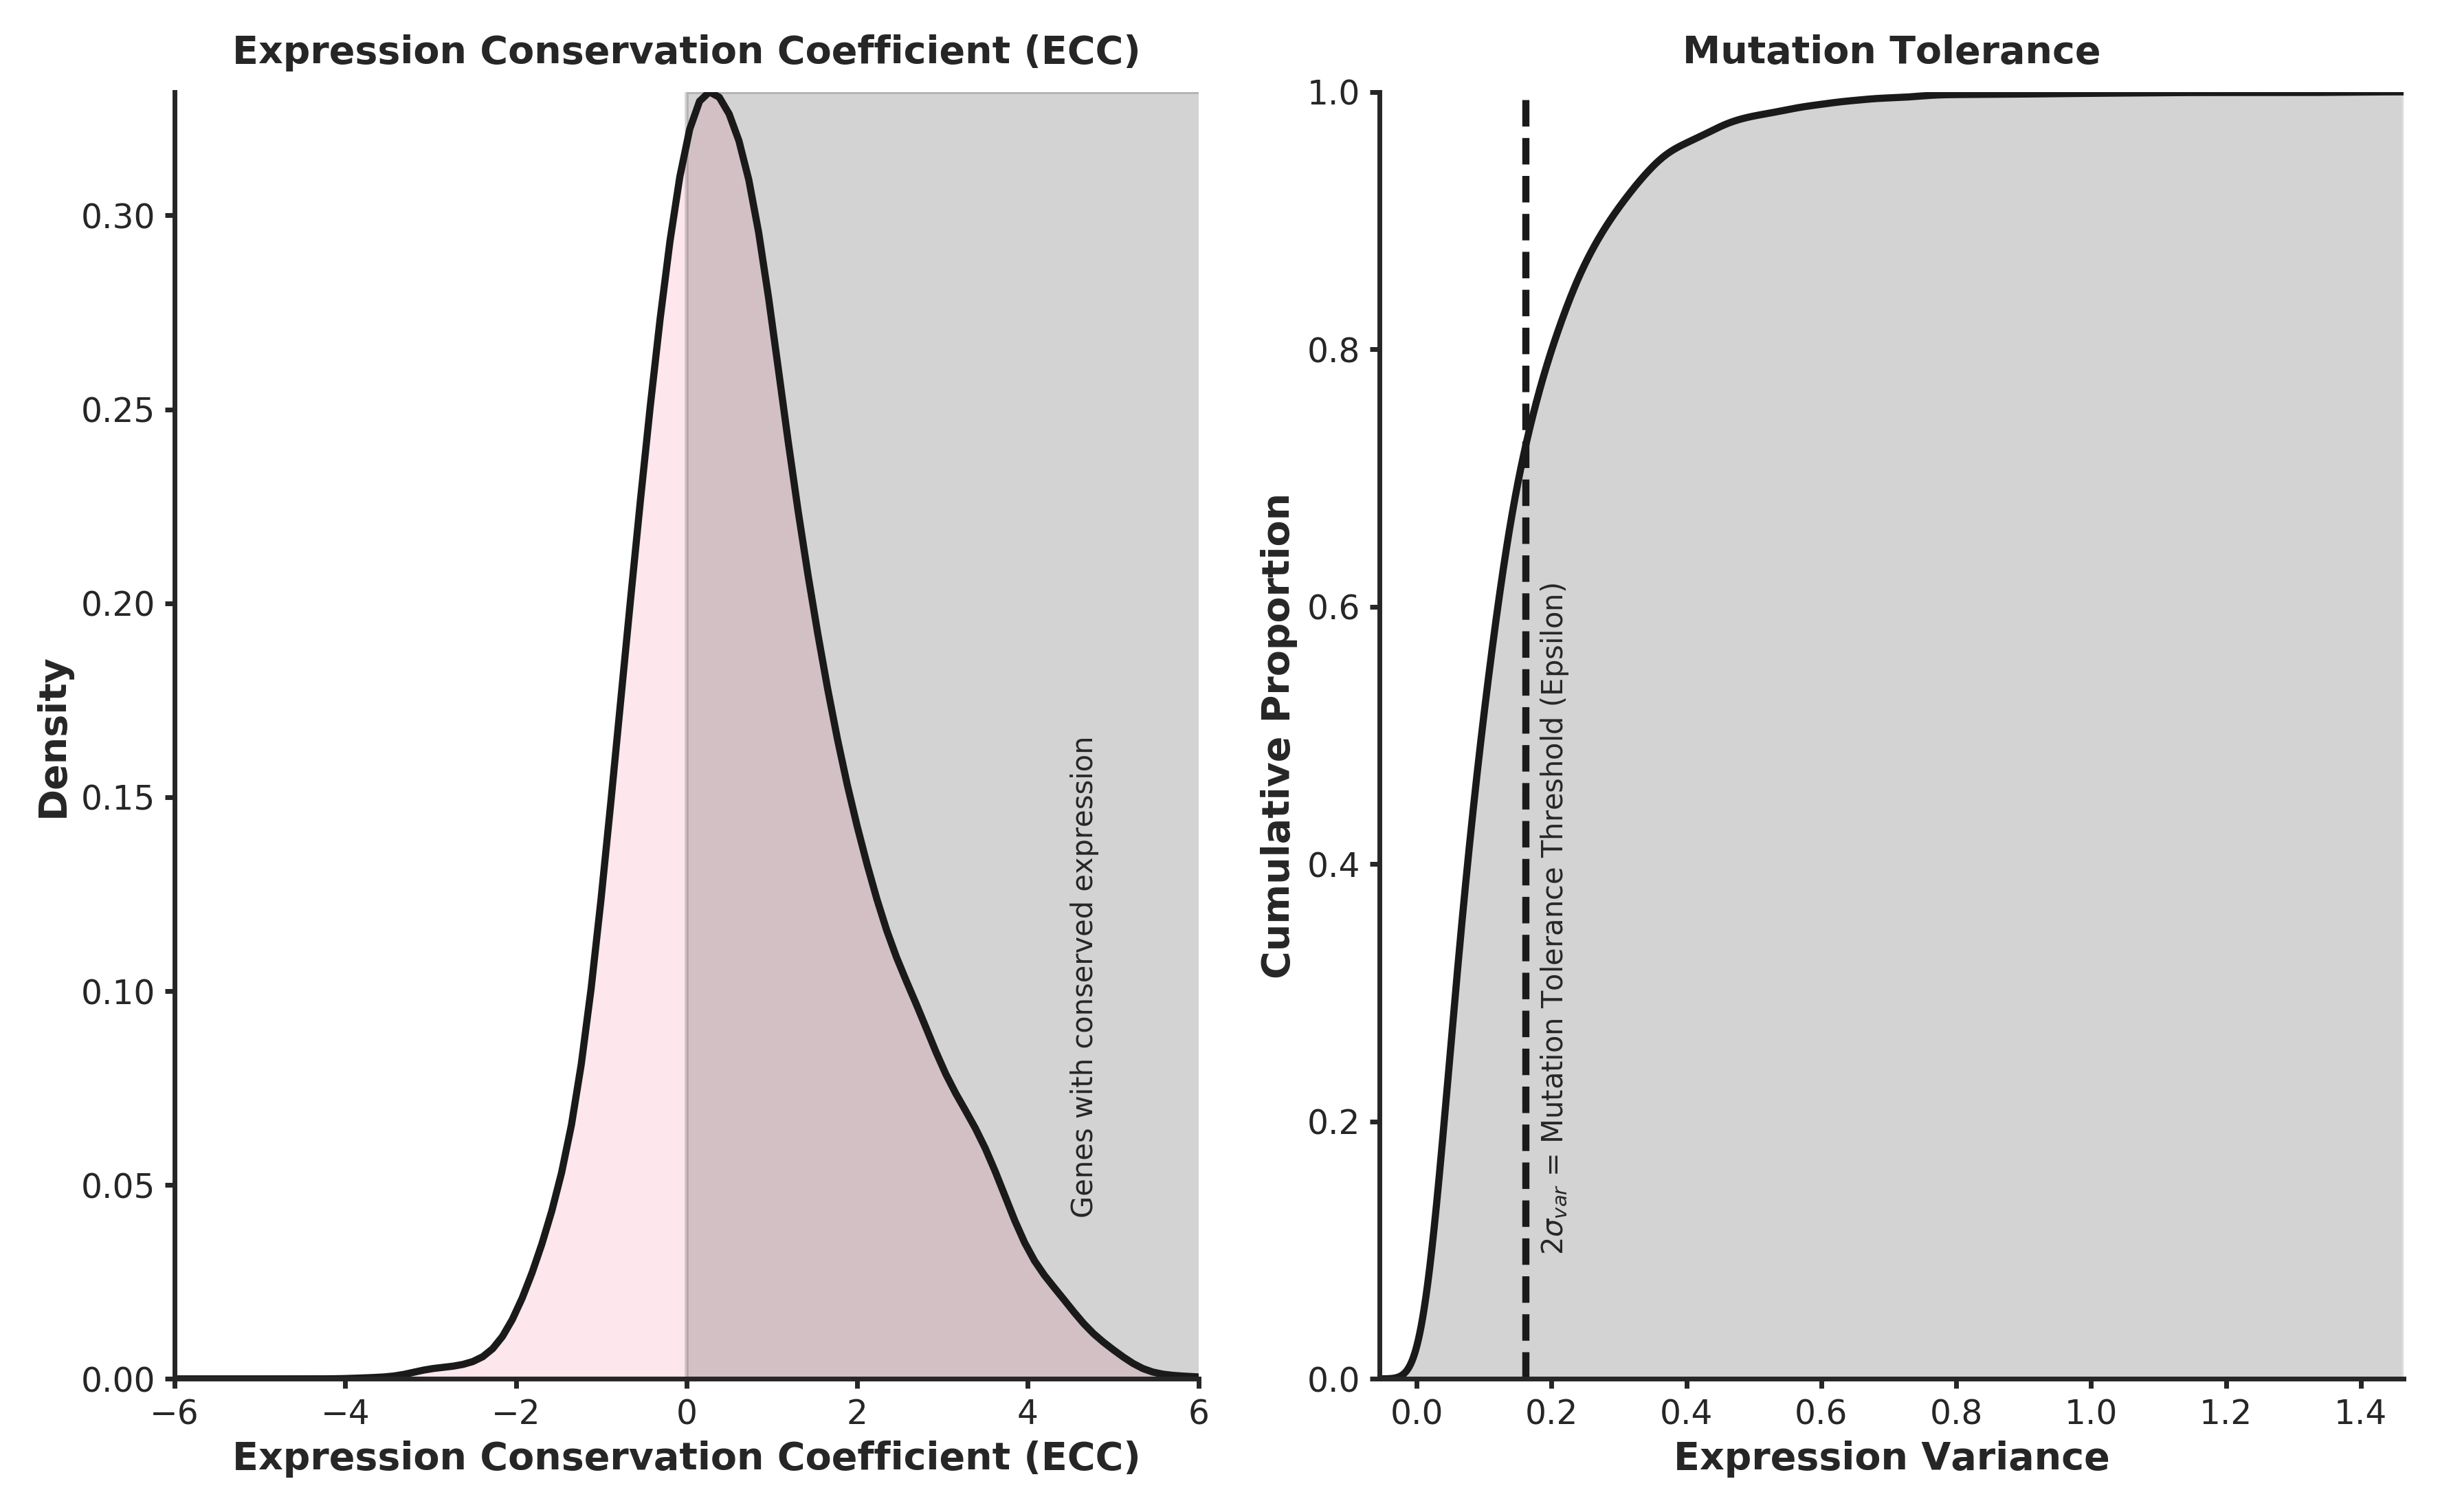

In [39]:
fig_file = "mutation_tolerance"


fig=plt.figure(figsize=(7.2,7.2/1.6) , dpi= 500, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


#### Panel 1 
plt.subplot(1, 2, 1)
data = pro_df.log_ratio.dropna()
sns.kdeplot(data, shade=1, c = '#fa9fb5' )
####
plt.axvspan(0, 14, alpha=0.25, color='#525252' )
plt.text(4.5,0.16,'Genes with conserved expression',fontsize=6, rotation=90 )



ax = plt.gca()
ax.get_legend().remove()


ax.set_xlabel("Expression Conservation Coefficient (ECC)")
ax.set_ylabel("Density")
ax.set_title("Expression Conservation Coefficient (ECC)")



plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
ax.set_xlim(xmin=-6,xmax=6)
#ax.set_ylim(ymin=0,ymax=0.17)




#### Panel 2 
plt.subplot(1, 2, 2)
data = np.sqrt(cons_df.var_EL_actual.dropna())

sns.kdeplot(data, c= '#525252', cumulative=1, shade=1, gridsize=2500 )

plt.axvline(epsilon, 0 , c='#525252'  , linestyle = '--')
plt.text(epsilon+0.02,0.6,'$2\sigma_{var}$ = Mutation Tolerance Threshold (Epsilon)',rotation=90 ,fontsize=6 )

ax = plt.gca()
ax.get_legend().remove()
ax.set_xlabel("Expression Variance"  )
ax.set_ylabel("Cumulative Proportion")
ax.set_title("Mutation Tolerance")

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)

#ax.set_xlim(xmin=-0.025,xmax=0.4)
#ax.set_ylim(ymin=0,ymax=1)
#ax.set_yticks( np.arange(0,1.05,0.05))

#ax.set_yticklabels([f'{i:0.2f}' for i in np.arange(0,1,0.05)])






plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()





### Compute Fitness Responsivity using the Total Variation of $F$ 

In [ ]:
glu_F = pd.ExcelFile('keren_Glu.xlsx' ) ### From Keren et al, Cell 2016
glu_wt_exp = pd.read_excel(glu_F, 'wt expression glucose' , index_col=0)
glu_wt_exp['glu_exp'] = glu_wt_exp['wt expression glucose']
glu_reads = pd.read_excel(glu_F, 'reads glucose', index_col=0)
glu_fitness_raw = pd.read_excel(glu_F, 'fitness data glucose', index_col=0)
glu_fitness_smooth = pd.read_excel(glu_F, 'impulse fit glucose', index_col=0)
glu_fitness_smooth.index.names = ['gene_name']
glu_quality = pd.DataFrame(glu_reads.sum(axis=1) , columns=['quality_glu'])
glu_quality = glu_quality.sort_values(by='quality_glu')
glu_quality = glu_quality.drop(index=np.setdiff1d(glu_quality.index , glu_fitness_smooth.index ))
glu_quality.index.names = ['gene_name']



gal_F = pd.ExcelFile('keren_Gal.xlsx' )  ### From Keren et al , Cell 2016
gal_wt_exp = pd.read_excel(gal_F, 'wt expression galactose', index_col=0)
gal_wt_exp['gal_exp'] = gal_wt_exp['wt expression galactose']
gal_reads = pd.read_excel(gal_F, 'reads galactose', index_col=0)
gal_fitness_raw = pd.read_excel(gal_F, 'fitness data galactose', index_col=0)
gal_fitness_smooth = pd.read_excel(gal_F, 'impulse fit galactose', index_col=0)
gal_fitness_smooth.index.names = ['gene_name']
gal_quality = pd.DataFrame(gal_reads.sum(axis=1) , columns=['quality_gal'])
gal_quality = gal_quality.sort_values(by='quality_gal')
gal_quality = gal_quality.drop(index=np.setdiff1d(gal_quality.index , gal_fitness_smooth.index ))
gal_quality.index.names = ['gene_name']



### Total Variation (tv_df)

In [23]:
if 0 : 
    tv_df = pd.DataFrame( )
    ##########
    ##########
    ##########
    ##########
    tv_gal_l1 = 0
    for i in tqdm(range(len(gal_fitness_smooth.columns)-1)) :
        tv_gal_l1 = tv_gal_l1 + np.abs((gal_fitness_smooth.iloc[:,i] - gal_fitness_smooth.iloc[:,i+1]))
    tv_df['tv_gal_l1'] = tv_gal_l1
    ##########
    tv_gal_l2 = 0
    for i in tqdm(range(len(gal_fitness_smooth.columns)-1)) :
        tv_gal_l2 = tv_gal_l2 + np.abs((gal_fitness_smooth.iloc[:,i] - gal_fitness_raw.iloc[:,i+1])**2 /
                                (gal_fitness_smooth.columns[i] - gal_fitness_smooth.columns[i+1]))
    tv_df['tv_gal_l2'] = np.sqrt(tv_gal_l2)
    ##########
    tv_df['fitness_effect_gal'] = 1 - gal_fitness_raw.min(axis=1) /gal_fitness_raw.max(axis=1)
    ##########
    ##########
    ##########
    ##########
    tv_glu_l1 = 0
    for i in tqdm(range(len(glu_fitness_smooth.columns)-1)) :
        tv_glu_l1 = tv_glu_l1 + np.abs((glu_fitness_smooth.iloc[:,i] - glu_fitness_smooth.iloc[:,i+1]))

    tv_df['tv_glu_l1'] = tv_glu_l1
    ##########
    tv_glu_l2 = 0
    for i in tqdm(range(len(glu_fitness_smooth.columns)-1)) :
        tv_glu_l2 = tv_glu_l2 + np.abs((glu_fitness_smooth.iloc[:,i] - glu_fitness_smooth.iloc[:,i+1])**2 /
                                      (glu_fitness_smooth.columns[i] - glu_fitness_smooth.columns[i+1]))
    tv_df['tv_glu_l2'] = np.sqrt(tv_glu_l2)
    ##########
    tv_df['fitness_effect_glu'] = 1 - glu_fitness_raw.min(axis=1)/glu_fitness_raw.max(axis=1)
    ##########
    if 0 :
        plt.figure(figsize=(3,3))
        x= tv_df.tv_gal
        y=tv_df.tv_glu
        sns.scatterplot(x , y )
        plt.title(scipy.stats.spearmanr(x,y , nan_policy='omit')[0])





    yeast_genome_annotations = pd.read_csv('yeast_genes.dict' , error_bad_lines=False , sep='\t', header=None)
    yeast_genome_annotations.columns=['systematic_name','gene_name' ,'bla']

    tv_df['gene_name'] = tv_df.index
    tv_df['systematic_name'] = tv_df.gene_name.apply(name2sys)
    tv_df['proName'] = tv_df['systematic_name']+'.2'
    pro_df['proName']=pro_df.index

    tv_df= tv_df.join(glu_wt_exp).join(gal_wt_exp).join(glu_quality,).join(gal_quality)
    tv_df = tv_df.merge(pro_df, on='proName' )
    tv_df.index = tv_df.gene_name
    tv_df.loc[:,'F_gal_var'] = gal_fitness_smooth.apply(np.var,axis=1)
    tv_df.loc[:,'F_glu_var'] = glu_fitness_smooth.apply(np.var,axis=1)
    tv_df.to_csv('tv_df.tsv',sep='\t')

else :
    tv_df = pd.read_csv('tv_df.tsv' , sep='\t')
    ## Drop rows with NA genes if any
    tv_df = tv_df.loc[tv_df[['gene_name','log_ratio' , 'mutation_tolerance' , 'tv_glu_l1']].dropna().index , :]
    

(0, 1.05)

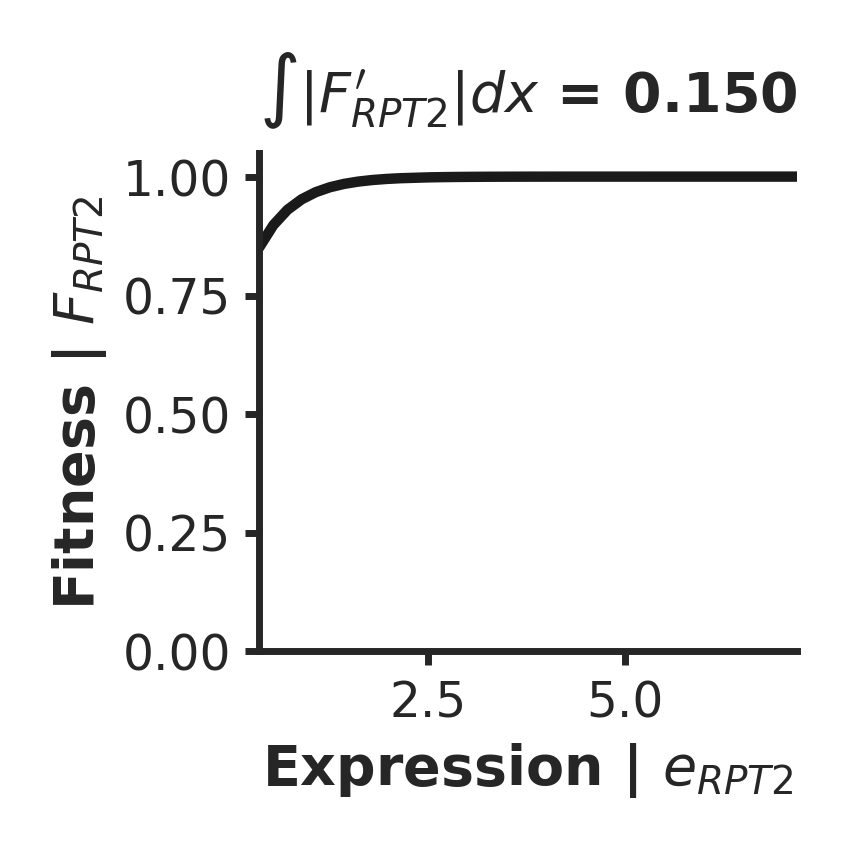

In [103]:

fig=plt.figure(figsize=(1.8,1.8) , dpi= 500, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

gene_name='RPT2'
tv_value = tv_df.loc[tv_df.gene_name==gene_name].tv_glu_l1
plt.plot(glu_fitness_smooth.loc[ gene_name, :])



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel('Expression | $e_{%s}$' %(gene_name ))
ax.set_ylabel('Fitness | $F_{%s}$' %(gene_name ) )
ax.set_title('$\int |F_{%s}\'|dx  $ = %.3f'%(gene_name , tv_value))


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-14,xmax=6)
ax.set_ylim(ymin=0,ymax=1.05)


### TV Calculation 

/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


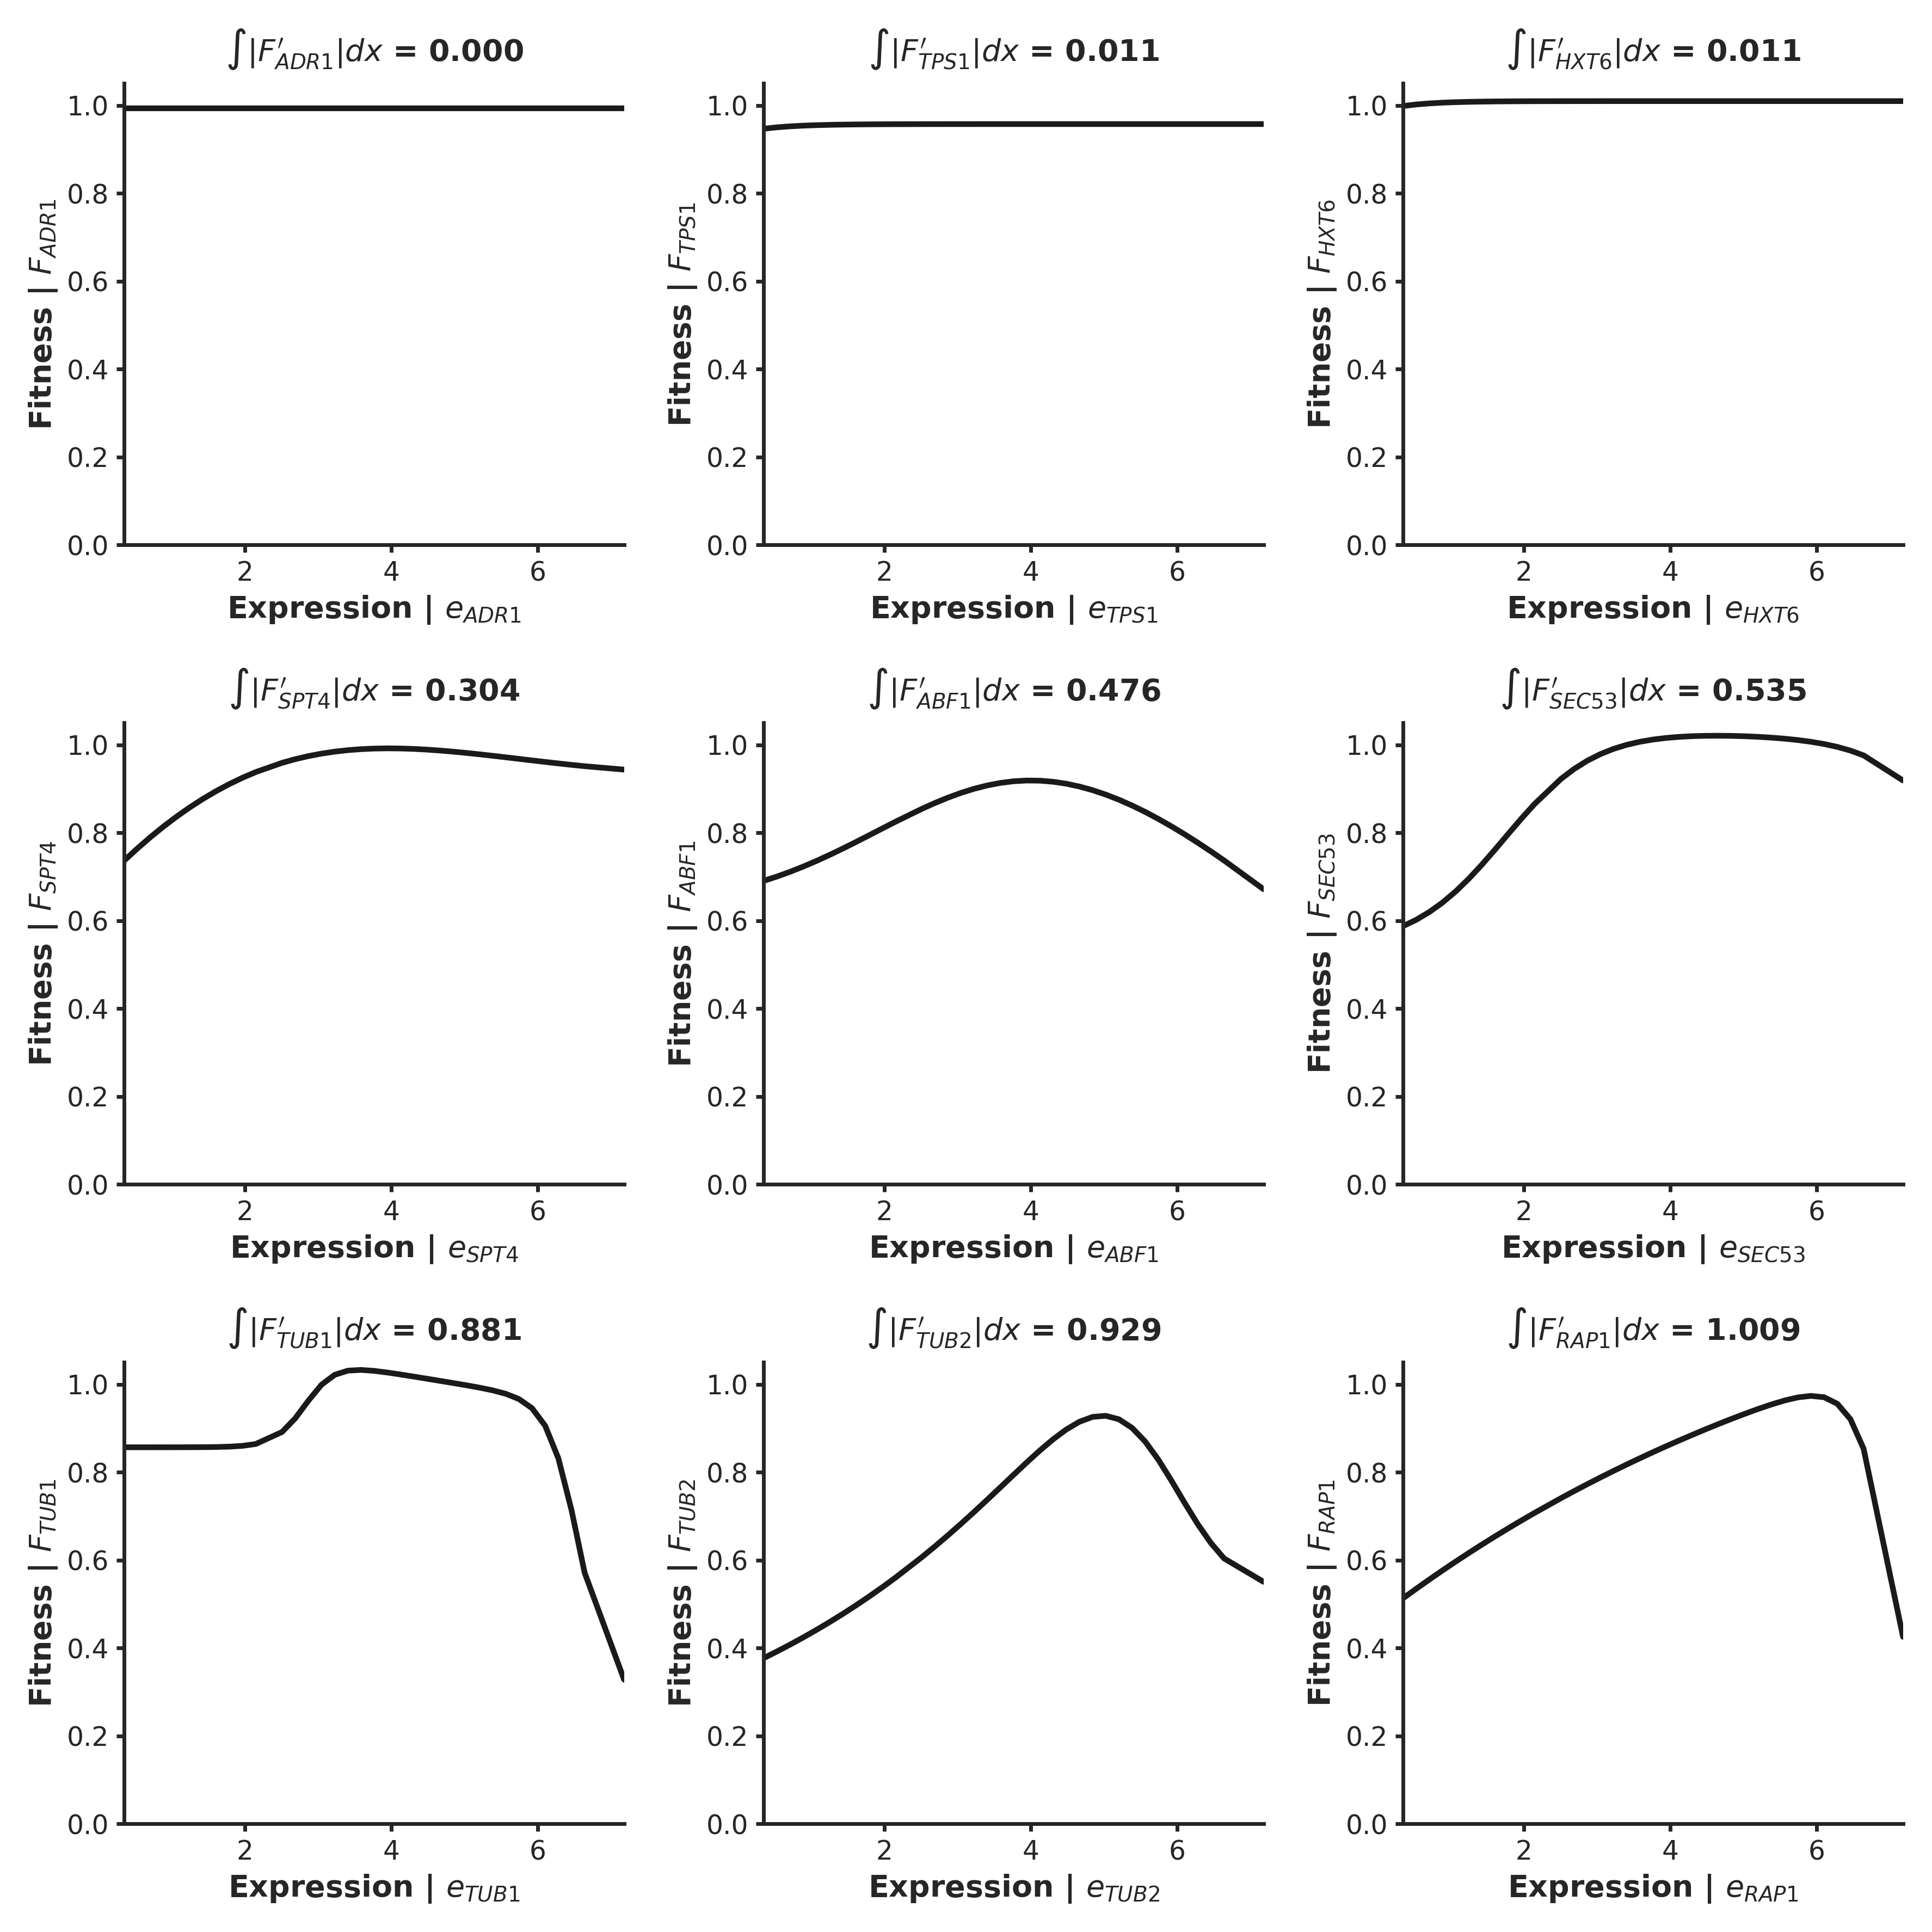

In [59]:
gene_list= [
    'ADR1' , #Non-essential gene involved in ethanol and fatty acid utilization + peroxisome organization
    'TPS1', #Stress response 
    'HXT6' , #Hexose transporter
    'SPT4' , #RNA Pol 1 and POl 2 binding TF
    'ABF1', #Chromosome remodelling and tx activation
    'SEC53' , # Folding and glycosylation of secretory proteins
    'TUB1' , #tubulin
    'TUB2' , #tubulin
    'RAP1' , # essential DNA binding TF that binds many locii , involved in tx activation and repression
 ]
########Multi Panel Figure Example
fig_file = "tv_calculation"


fig=plt.figure(figsize=(7.2,7.2) , dpi= 500, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)


for i in range(len(gene_list)) :
    gene_name = gene_list[i]


    plt.subplot(3, 3, i+1)
    tv_value = tv_df.loc[tv_df.gene_name==gene_name].tv_glu_l1
    plt.plot(glu_fitness_smooth.loc[ gene_name, :])



    ax = plt.gca()
    #ax.get_legend().remove()


    ax.set_xlabel('Expression | $e_{%s}$' %(gene_name ))
    ax.set_ylabel('Fitness | $F_{%s}$' %(gene_name ) )
    ax.set_title('$\int |F_{%s}\'|dx  $ = %.3f'%(gene_name , tv_value))


    plt.setp(ax.artists, edgecolor = 'k')
    plt.setp(ax.lines, color='k')
    plt.setp(ax.lines, linewidth=1.5)

    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    #ax.set_xlim(xmin=-14,xmax=6)
    ax.set_ylim(ymin=0,ymax=1.05)






plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

